# Analyzing simple experiments

This notebook shows you how to analyze simple experiments. We expect basic knowledge from CCS1 and CCS2 - have a look at the course materials if you are unsure.

In [1]:
# only need to install this once, it's for some SPSSy stuff used in Psychology but not often used in Python
!pip install psython
!pip install pingouin
!pip install prettytable
!pip install factor_analyzer

In [2]:
import pandas as pd
import seaborn as sns
from statsmodels.formula.api import ols
import numpy as np
import psython as psy
import pingouin as pg
# from scipy.stats import chi2_contingency
from scipy.stats import contingency 
from factor_analyzer import FactorAnalyzer

## Loading the dataset

We first load the dataset and inspect it.
We also do necessary recoding.
Note that this is a "fake" dataset with data I simulated; also note that your dataset may look slightly different. You should know everything about loading, recoding etc. from CCS1 and CCS2.

In [3]:
df = pd.read_csv("data.csv")
df

,dv,group,gender,age,x1,x2,x3,x4,x5
0,3.125799,1,male,26,2.096090,1.867097,2.648194,0.116307,2.935158
1,2.366678,1,female,24,1.635612,1.340803,2.005062,0.088061,2.222336
2,3.013840,1,male,18,2.028176,1.789477,2.553342,0.112141,2.830028
3,1.856299,1,male,27,1.326019,0.986961,1.572667,0.069070,1.743085
4,3.788798,1,female,22,2.498261,2.326750,3.209890,0.140976,3.557722
...,...,...,...,...,...,...,...,...,...
360,3.194810,4,female,25,2.137951,1.914942,2.706660,0.118875,2.999960
361,4.590034,4,male,18,2.984286,2.882242,3.888702,0.170789,4.310091
362,4.089445,4,male,20,2.680631,2.535187,3.464600,0.152163,3.840033
363,3.443459,4,female,20,2.288780,2.087328,2.917317,0.128127,3.233444


### Let's look at what we have:

In [4]:
df['dv'].describe()

count    365.000000
mean       3.383098
std        0.755077
min        1.428526
25%        2.865476
50%        3.390215
75%        3.897036
max        5.802799
Name: dv, dtype: float64

In [5]:
df['group'].value_counts(sort=False)

1     98
2     77
3    102
4     88
Name: group, dtype: int64

In [6]:
df['gender'].value_counts(sort=False)

female    172
male      193
Name: gender, dtype: int64

In [7]:
df['age'].describe()

count    365.000000
mean      22.736986
std        2.902609
min       18.000000
25%       20.000000
50%       23.000000
75%       25.000000
max       27.000000
Name: age, dtype: float64

<AxesSubplot:xlabel='age', ylabel='count'>

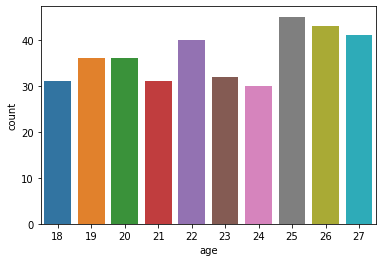

In [8]:
#or some plotting if we like
sns.countplot(x='age', data=df)

<AxesSubplot:xlabel='dv', ylabel='Count'>

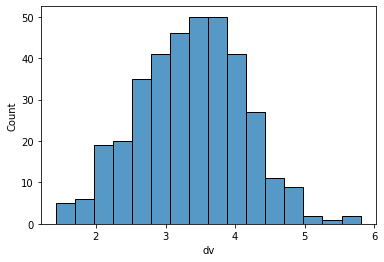

In [9]:
sns.histplot(x='dv', data=df)

## Some recoding

Let's consider the variable `x1a` below. As we see, it is a variable that consists of four possible values: 1, 2, 3, 4. We will do two things:
- Reverse-code it (such that 4 becomes 1, 3 becomes 2, 2 becomes 3, and 1 becomes 4).
- Dichotomize it (such that 1 and 2 become 0 and 3 and 4 become 1)

count    365.000000
mean       2.260274
std        0.570025
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: x1a, dtype: float64


<AxesSubplot:xlabel='x1a', ylabel='count'>

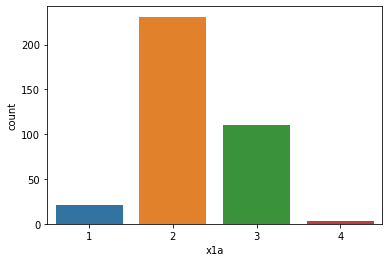

In [10]:
# Let's consider the variable x1a below:
df['x1a'] = df['x1'].round().map(int)
print(df['x1a'].describe())
sns.countplot(x='x1a', data=df)

### Reverse code

In [11]:
# We can either do it with a fancy formula: 
# we multiply the variable with -1 and then add the highest value + 1 (thus, 5 in our case)
# check it with pen and paper, it works ;-)
df['x1a_reverse-1'] = (df['x1a'] * -1 + df['x1a'].max() + 1)

# or we do it explicitly
df['x1a_reverse-2'] = df['x1a'].map({4:1, 3:2, 2:3, 1:4})

### Dichotomize

In [12]:
# again, a formula ...
df['x1a_dichotomous-1'] = (df['x1a']>=3).map(int)

# or we do it explicitly
df['x1a_dichotomous-2'] = df['x1a'].map({4:1, 3:1, 2:0, 1:0})

### Let's have a look at all our recoded colulms:

In [13]:
df[[col for col in df if col.startswith('x1a')]]

,x1a,x1a_reverse-1,x1a_reverse-2,x1a_dichotomous-1,x1a_dichotomous-2
0,2,3,3,0,0
1,2,3,3,0,0
2,2,3,3,0,0
3,1,4,4,0,0
4,2,3,3,0,0
...,...,...,...,...,...
360,2,3,3,0,0
361,3,2,2,1,1
362,3,2,2,1,1
363,2,3,3,0,0


### Advanced stuff: Create new variable based on multiple columns
Imagine  you want to create a nominal variable, say, `mygroups` based on multiple other columns. You can do that using a function:

In [14]:
def makemygroups(row):
    # any combination of contitions can be entered here
    if row['x1a_dichotomous-1'] == 0 and row['x2']<2:
        return "group1"
    elif row['x1a_dichotomous-1'] == 1 and row['x2']<3:
        return "group2"
    else:
        return "no group"
    
df['mygroups'] = df.apply(makemygroups,axis=1)
df['mygroups'].value_counts()

group1      169
group2       99
no group     97
Name: mygroups, dtype: int64

## Some simple group comparison

<AxesSubplot:xlabel='group', ylabel='dv'>

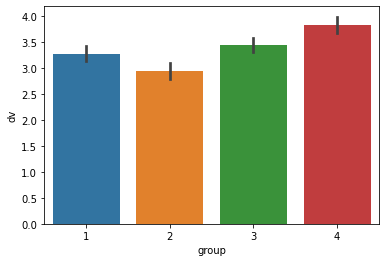

In [15]:
sns.barplot(y='dv', x='group', data=df)

<AxesSubplot:xlabel='group', ylabel='dv'>

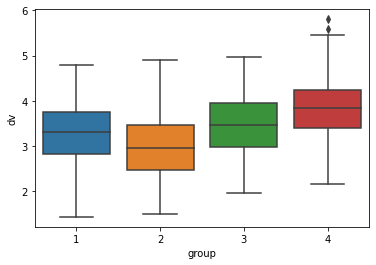

In [16]:
# maybe a boxplot is nicer?

sns.boxplot(y='dv', x='group', data=df)

In [17]:
# how does the dv differ?
df.groupby('group')['dv'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
1,98.0,3.272706,0.691306,1.428526,2.821665,3.305498,3.760571,4.796552
2,77.0,2.941768,0.695712,1.493880,2.463041,2.946119,3.470892,4.906704
3,102.0,3.439727,0.675162,1.948577,2.983307,3.470620,3.943603,4.973289
4,88.0,3.826560,0.715388,2.153351,3.396277,3.830987,4.245062,5.802799


In [18]:
# This is how one could compare the groups using a regresion analysis. Uncomment the following line if you want to see.

ols("dv~C(group) + age + C(gender)", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     dv   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     14.36
Date:                Tue, 28 Jun 2022   Prob (F-statistic):           7.91e-13
Time:                        14:15:06   Log-Likelihood:                -381.59
No. Observations:                 365   AIC:                             775.2
Df Residuals:                     359   BIC:                             798.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.3063      0.297     11.119      0.000       2.722       3.891
C(group)[T.2]        -0.3379      0.106     -3.192      0.002      -0.546      -0.130
C(group)[T.3]         0.1757      0.099      1.783      0.075      -0.018       0.370
C(group)[T.4]         0.5491      0.102      5.380      0.000       0.348       0.750
C(gender)[T.male]    -0.0926      0.073     -1.260      0.208      -0.237       0.052
age                   0.0007      0.013      0.054      0.957      -0.024       0.025
==============================================================================
Omnibus:                        0.135   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.935   Jarque-Bera (JB):                0.254
Skew:                           0.001   Prob(JB):                        0.881
Kurtosis:                       2.871   Cond. No.                         189.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# All analyses from the slides

In this section of the notebook, we show *all* analyses from the lecture slides and how to do them in Python, in the order in which they are mentioned on the slides.

Check for more simple analyses https://pingouin-stats.org/ (including mediation analysis!)

For everything related to regression (and more advanced stuff), you may want to have a look at https://www.statsmodels.org/.


## Check validity (Factor analysis)
factor analysis requires multiple steps, for a comprehensive guide check this link.
https://www.datacamp.com/tutorial/introduction-factor-analysis

## Check reliability (Cronbach's Alpha)

Let's check whether the variables called `x1, x2, x3, x4, x5` measure the same construct: 

In [19]:
alpha, report = psy.cronbach_alpha_scale_if_deleted(df[['x1','x2','x3','x4','x5']])

print(f"Cronbach's alpha={alpha[0]:.3f}, confidence interval= {alpha[1]}")
report

Cronbach's alpha=0.936, confidence interval= [0.925 0.946]


,Item,Scale Mean if Item Deleted,Scale Variance if Item Deleted,Corrected Item-Total Correlation,Cronbach's Alpha if Item Deleted
0,x1,8.214305,3.611207,1.0,0.895152
1,x2,8.420990,3.366683,1.0,0.888774
2,x3,7.600292,2.953713,1.0,0.887641
3,x4,10.340590,5.430052,1.0,0.990606
4,x5,7.289706,2.720246,1.0,0.895215


### If we are satisfied, maybe make a new variable by calculating the mean

In [20]:
df['scale_x'] = df[['x1','x2','x3','x4','x5']].mean(axis=1)   # of course, only select those you're interested in

## $\chi^2$ -test (chi2-test)

In [21]:
#let's look at the crosstab
mycrosstab = pd.crosstab(df['gender'], df['x1a_dichotomous-1'])
mycrosstab

x1a_dichotomous-1,0,1
gender,,
female,110,62
male,142,51


In [22]:
# and then get the chi2 test for that table
c, p, dof, expected = contingency.chi2_contingency(mycrosstab)
print(f"𝜒²({dof:.0f}) = {c:.3f}, p = {p:.3f} ")

# maybe Cramer's V as well?
print(f"V = {contingency.association(mycrosstab,method='cramer'):.3f}")

𝜒²(1) = 3.502, p = 0.061 
V = 0.104


### Levene's test

In [23]:
from scipy.stats import levene

# Create three arrays for each sample:
groupf = df.query('gender == "female"')['dv']
groupm = df.query('gender == "male"')['dv']

# Levene's Test in Python with Scipy:
stat, p = levene(groupf, groupm)

print(stat, p)

2.582366071212631 0.1089294800350779


## t-test

You only need to specify the variable you group by (gender) and the variable you want to test (dv) in the first line of the code and we'll print a nicely formated sentence! (plus the table)

In [24]:
(label1, values1), (label2, values2) = df.groupby('gender')['dv']

testresult = pg.ttest(values1, values2)

print(f"We compare {label1} (M={np.mean(values1):.2f}, SD={np.std(values1):.3f}) "
     f"with {label2} (M={np.mean(values2):.2f}, SD={np.std(values2):.3f}), "
     f"t({testresult.iloc[0,1]})={testresult.iloc[0,0]:.3f}, "
     f"p={testresult.iloc[0,3]:.4f}.")

testresult

We compare female (M=3.43, SD=0.791) with male (M=3.35, SD=0.718), t(347.346215441861)=0.995, p=0.3203.


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.995357,347.346215,two-sided,0.320255,"[-0.08, 0.24]",0.10496,0.187,0.169661


## ANOVA


In [25]:
aov = pg.anova(data=df, dv='dv', between='group', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,group,33.824756,3,11.274919,23.431682,7.029862e-14,0.162986
1,Within,173.706936,361,0.481183,NaN,NaN,NaN


In [26]:
# post-hoc test
df.pairwise_tukey(dv='dv', between='group').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1,2,3.273,2.942,0.331,0.106,3.133,0.010,0.475
1,1,3,3.273,3.440,-0.167,0.098,-1.702,0.324,-0.240
2,1,4,3.273,3.827,-0.554,0.102,-5.437,0.000,-0.795
3,2,3,2.942,3.440,-0.498,0.105,-4.755,0.000,-0.715
4,2,4,2.942,3.827,-0.885,0.108,-8.174,0.000,-1.270
5,3,4,3.440,3.827,-0.387,0.101,-3.833,0.001,-0.555


## ANOVA with interaction effect

Let's say we don't have a `1x4` but a `2x2` design:

In [27]:
# imagine that group 1 is personalized and interactive, 2 is only personalized, 3 is not interactive but personalized, and 4 is neither
df['personalized']=False
df['interactive']=False
df.loc[df['group']==1,'personalized']=True
df.loc[df['group']==2,'personalized']=True
df.loc[df['group']==1,'interactive']=True
df.loc[df['group']==3,'interactive']=True

In [28]:
df.anova(dv="dv", between=["interactive", "personalized"],effsize="n2").round(3)

,Source,SS,DF,MS,F,p-unc,n2
0,interactive,0.177,1.0,0.177,0.369,0.544,0.001
1,personalized,21.929,1.0,21.929,45.574,0.000,0.106
2,interactive * personalized,11.614,1.0,11.614,24.137,0.000,0.056
3,Residual,173.707,361.0,0.481,NaN,NaN,NaN


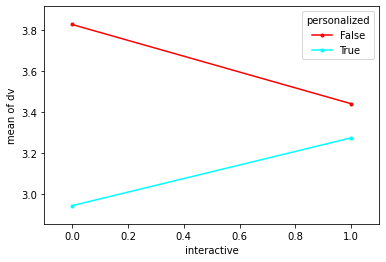

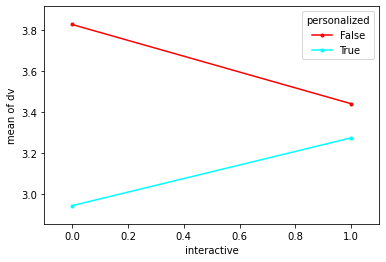

In [29]:
# I don't think one should do this when the x-axis is continous, but ANOVA-people sometimes do this:

from statsmodels.graphics.factorplots import interaction_plot
interaction_plot(df['interactive'], df['personalized'], df['dv'])

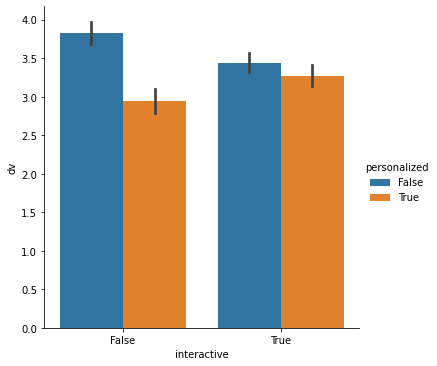

In [30]:
# better plot:
sns.catplot(x='interactive', y='dv', hue='personalized', kind='bar', data=df)

## ANCOVA

In [31]:
df['gender_int'] = df['gender'].map({"male":1,"female":0})

In [32]:
pg.ancova(data=df, dv='dv', covar=['age', 'gender_int'], between='group',effsize="n2")

,Source,SS,DF,F,p-unc,n2
0,group,34.018652,3,23.539438,6.243035e-14,0.163768
1,age,0.001413,1,0.002933,9.568421e-01,0.000007
2,gender_int,0.764853,1,1.587736,2.084684e-01,0.003682
3,Residual,172.939507,359,NaN,NaN,NaN


## Mediation Analysis
Let's assume that we want to recode `x1, x2, ... x5` from the dataframe above into `some_mediator` (see Cronbach's alpha above) and test the model `age --> some_mediator --> dv`:

In [33]:
df['some_mediator'] = df[['x1','x2','x3','x4','x5']].mean(axis=1)

In [34]:
pg.mediation_analysis(data=df, x='age', m='some_mediator', y='dv', seed=42, n_boot=1000)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,some_mediator ~ X,-5.037270e-04,8.528899e-03,9.529359e-01,-1.727598e-02,1.626853e-02,No
1,Y ~ some_mediator,1.600865e+00,6.613594e-17,0.000000e+00,1.600865e+00,1.600865e+00,Yes
2,Total,-8.063987e-04,1.365361e-02,9.529359e-01,-2.765651e-02,2.604371e-02,No
3,Direct,5.551115e-17,1.054551e-17,2.421698e-07,3.477301e-17,7.624930e-17,Yes
4,Indirect,-8.063987e-04,1.336574e-02,9.800000e-01,-2.775583e-02,2.414019e-02,No


We see that there is only an effect `x-->some_mediator`, all other arrows are insignificant.